### IMPORT PACKAGES & FUNCTIONS

In [22]:
import hdbscan
import random
from sklearn.metrics import silhouette_score
from Recommendation_System_Location_Based_Pre_Work import df2_co_topcat
from Recommendation_System_Location_Based_Pre_Work import mapVisualize
from Recommendation_System_Location_Based_Pre_Work import addPredictedClusters
from Recommendation_System_Location_Based_Pre_Work import numOfClusters

In [44]:
#Functions

#This function takes the appended clusters to df2_co_top and creates popularity df called recomm_df
def create_recomm_dataframe(cluster):
    recomm_df = df2_co_topcat.copy()
    recomm_df = (recomm_df.groupby([cluster, 'merchant']).agg({'latitude' : 'first',
                                                  'longitude' : 'first',
                                                  'city' : 'first',
                                                  'category' : 'first',
                                                   cluster : 'count'})
          .rename({cluster : 'cluster_count'},axis=1).reset_index()
          .sort_values([cluster, 'cluster_count'], ascending = [True, False])
          .drop('cluster_count', axis=1))
    return recomm_df

In [45]:
df2_co_topcat.info() #5141 non-null entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5141 entries, 0 to 5140
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uid                                  5141 non-null   object 
 1   category                             5141 non-null   object 
 2   categoryid                           5141 non-null   float64
 3   merchant                             5141 non-null   object 
 4   city                                 5141 non-null   object 
 5   latitude                             5141 non-null   float64
 6   longitude                            5141 non-null   float64
 7   kmeans_lat_long_cluster5             5141 non-null   int32  
 8   cityTransformed                      5141 non-null   int32  
 9   kmeans_lat_long_city_catid_cluster7  5141 non-null   int32  
dtypes: float64(3), int32(3), object(4)
memory usage: 341.5+ KB


### Current view of transactions on the map

In [19]:
mapVisualize(df2_co_topcat,"latitude","longitude",'category','Current_Transactions_Map_Over_CO') #Visualize clusters on the map

#### From above map, we can see that there are clearly "outliers" i.e. points that will not or should not be part of clusters. The clusters produced by the clustering algorithm should mark outliers as noise and seperate them from the island clusters with data points that are closest to each other. 

##############################################################################################################################

## Clustering

## 1. KMEANS
##### df_cluster= df2_co_topcat ['latitude','longitude']

1a: Elbow Method to find if there are any visiable clusters.

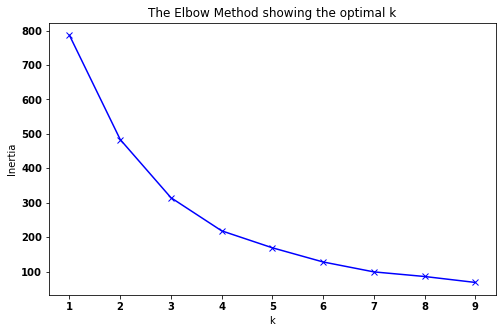

In [91]:
#Kmeans - finding clusters in dataframe with lat and long only
df_cluster=df2_co_topcat[['latitude','longitude']]

#The elbow method to see optimal number of clusters (k)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
elbowMethod(ax,df_cluster,10)

#fig.savefig('knee-elbow.jpg', bbox_inches = "tight")

After calculating silhouette scores and cluster distributions for k=3,4,5,6,7 
I have determined that k=5 with sil_score of 0.66 is the best one for this experiment.
Note: It is highly unbalanced clusters but it is the best among other k values

In [92]:
#cluster generation and sil_core for k=5 with df_cluster=[[lat,long]]
dict_cluster={5:'cluster5'}

for numclust,nameclust in dict_cluster.items():
    clustername=nameclust
    title="KMeans-lat_lon_TopCat" +"-" + nameclust
    clusterNum=numclust
    clusters,kmeans5=findKmeans(df_cluster,clusterNum)

    df2_co_topcat=addPredictedClusters(df2_co_topcat,clusters,clustername)  #Add new predicted cluster to the dataframe
    #mapVisualize(df2_co_topcat,"latitude","longitude",clustername,title) #Visualize clusters on the map
    print(numOfClusters(df2_co_topcat,clustername))#Find distribution of data within each cluster

 
k =  5 silhouette_score  0.66496672179331
 
cluster5     0    1   2   3   4
count     4170  815  94  12  50


### Recommendation Engine Code -  recommend_co_merchants_kmeans
df_cluster=[[latitude,longitude]]

1. Create a dataframe (recomm_df) from df2_co_topcat that contains merchants per tagged clusters and the number of transactions(popularity criteria) per merchant. The most popular merchants per cluster are on top of the recomm_df dataframe. 
It also contains the latitude/longitude information and city the recommended merchant is in.

In [93]:
recomm_df=create_recomm_dataframe('cluster5')

2. Recommendation engine will first use method of kmeans called "predict" to predict the cluster of the given point (lat,long).
3. It will then match the predicted cluster with the 'cluster5' column of recomm_df.
4. Top 5 merchants based on popularity of the merchants are then displayed. The display contains the name, city, lat/long of the recommended merchants.

In [94]:
def recommend_co_merchants_kmeans5(df,lat,long,city,merchant):
    
  
    # Predict the cluster for longitude and latitude provided
    predicted_cluster= kmeans5.predict(np.array([lat,long]).reshape(1,-1))[0]
 
    print('Predicted cluster for this lat/long combination is: '  + str(predicted_cluster))
    print("_______________________________________________________________________________")
      # Get the best merchant in this cluster
    
    pop_merch_recomm_df=(df[df['cluster5']==predicted_cluster].iloc[0:5][['merchant','city','latitude','longitude']])
    pop_merch_recomm_df=pop_merch_recomm_df.reset_index(drop=True)
    mask = (pop_merch_recomm_df.merchant==merchant) & (pop_merch_recomm_df.latitude==lat) & (pop_merch_recomm_df.longitude==long)
    print ('Since you are currently in '+ city.capitalize() + ' ' + 'at ' + merchant.capitalize() + ', how about you visit these merchants around this area? ')
    return pop_merch_recomm_df[~mask]


## Test 1:

#### 1. Select a random row in df2_co_topcat dataframe and extract the lat, long ,city and merchant information. 

In [114]:
test_index=df2_co_topcat.sample(random_state=42).index.tolist()
test_index[0]
test_lat=df2_co_topcat.iloc[test_index[0]]['latitude']
test_long=df2_co_topcat.iloc[test_index[0]]['longitude']
test_city=df2_co_topcat.iloc[test_index[0]]['city']
test_merchant=df2_co_topcat.iloc[test_index[0]]['merchant']
test_catid=df2_co_topcat.iloc[test_index[0]]['categoryid']
test_cityTransformed=df2_co_topcat.iloc[test_index[0]]['cityTransformed']
test_lat, test_long, test_city, test_merchant

(40.016358, -105.130597, 'Lafayette', 'conoco gas station')

#### 2.  Provide the collected informaiton to the 'recommend_co_merchants_kmeans' func

In [96]:
recommend_co_merchants_kmeans5(recomm_df,test_lat,test_long,test_city,test_merchant)

Predicted cluster for this lat/long combination is: 0
_______________________________________________________________________________
Since you are currently in Lafayette at Conoco gas station, how about you visit these merchants around this area? 


,merchant,city,latitude,longitude
0,king soopers,Lafayette,40.00163,-105.10196
1,costco,Thornton,39.99163,-104.98236
2,safeway,Boulder,40.01375,-105.28406
3,the home depot,Longmont,40.15582,-105.13232
4,walmart,Westminster,39.88910,-105.08214


## RESULTS:
### Results <u>do not</u> reflect correct "close-by" coordinates when kmeans is used. 

In [98]:
#cleaning previous kmean's clusters from df2_co_topcat
df2_co_topcat.drop(['cluster5'],axis=1,inplace=True)

####################################################################################################################

## 2. KMEANS
##### df_cluster= df2_co_topcat ['latitude','longitude','city','categoryid']

2a:Transforming <b>city</b> into integers before using for KMeans

In [99]:
col_transformed(df2_co_topcat,'city','cityTransformed') #for kmeans columns need to be numerical. Therefore transforming city into numerical columns

2c: Elbow Method to find if there are any visiable clusters.

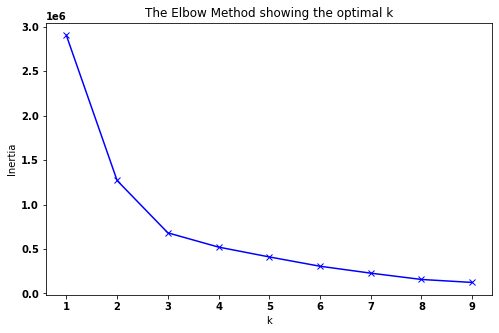

In [100]:
#Kmeans - finding clusters in dataframe with lat,long,cityTransformed,categoryid only
df_cluster=df2_co_topcat[['latitude','longitude','cityTransformed','categoryid']]

#The elbow method to see optimal number of clusters (k)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
elbowMethod(ax,df_cluster,10)

#fig.savefig('knee-elbow.jpg', bbox_inches = "tight")

After calculating silhouette scores and cluster distributions for k=3,4,5,6,7 
I have determined that k=7 with sil_score of 0.60 is the best one for this experiment.
Note: It is highly unbalanced clusters but it is the best among other k values#### Perhaps k=3,4,5,6,7

In [101]:
dict_cluster={7:'cluster7'}

for numclust,nameclust in dict_cluster.items():
    clustername=nameclust
    title="KMeans-lat_lon_TopCat" +"-" + nameclust
    clusterNum=numclust
    clusters,kmeans7=findKmeans(df_cluster,clusterNum)

    df2_co_topcat=addPredictedClusters(df2_co_topcat,clusters,clustername)  #Add new predicted cluster to the dataframe
    #mapVisualize(df2_co_topcat,"latitude","longitude",clustername,title) #Visualize clusters on the map
    print(numOfClusters(df2_co_topcat,clustername))#Find distribution of data within each cluster

 
k =  7 silhouette_score  0.6012389982472632
 
cluster7    0    1     2    3    4    5     6
count     286  904  1078  506  815  334  1218


### Recommendation Engine Code -  recommend_co_merchants_kmeans
df_cluster=[[latitude,longitude,cityTransformed,categoryid]]

1. Create a dataframe (recomm_df) from df2_co_topcat that contains merchants per tagged clusters and the number of transactions(popularity criteria) per merchant. The most popular merchants per cluster are on top of the recomm_df dataframe. 
It also contains the latitude/longitude information and city the recommended merchant is in.

In [102]:
recomm_df=create_recomm_dataframe('cluster7')

2. Recommendation engine will first use method of kmeans called "predict" to predict the cluster of the given point (lat,long).
3. It will then match the predicted cluster with the 'cluster7' column of recomm_df.
4. Top 5 merchants based on popularity of the merchants are then displayed. The display contains the name, city, lat/long of the recommended merchants.

In [118]:
def recommend_co_merchants_kmeans7(df,lat,long,city,cityTransformed,merchant,catid):
    # Predict the cluster for longitude and latitude provided
    predicted_cluster= kmeans7.predict(np.array([lat,long,cityTransformed,catid]).reshape(1,-1))[0]
 
    print('Predicted cluster for this lat/long combination is: '  + str(predicted_cluster))
    print("_______________________________________________________________________________")
      # Get the best merchants in this cluster
    
    pop_merch_recomm_df=(df[df['cluster7']==predicted_cluster].iloc[0:5][['merchant','city','latitude','longitude']])
    pop_merch_recomm_df=pop_merch_recomm_df.reset_index(drop=True)
    mask = (pop_merch_recomm_df.merchant==merchant) & (pop_merch_recomm_df.latitude==lat) & (pop_merch_recomm_df.longitude==long)
    print ('Since you are currently in '+ city.capitalize() + ' ' + 'at ' + merchant.capitalize() + ', how about you visit these merchants around this area? ')
    return pop_merch_recomm_df[~mask]

In [119]:
recommend_co_merchants_kmeans7(recomm_df,test_lat,test_long,test_city,test_cityTransformed,test_merchant,test_catid)

Predicted cluster for this lat/long combination is: 6
_______________________________________________________________________________
Since you are currently in Lafayette at Conoco gas station, how about you visit these merchants around this area? 


,merchant,city,latitude,longitude
0,king soopers,Lafayette,40.00163,-105.10196
1,tractor supply company,Lafayette,39.97453,-105.09038
2,natural grocers,Longmont,40.19033,-105.10397
3,the home depot,Longmont,40.15582,-105.13232
4,lowe's,Longmont,40.15250,-105.08631
